# Python (slightly) advanced topics
Author = R. Patrick Xian  
Date = 09/2017

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## 1. PyQt (see Faruk's notes)
Package for GUI design

## 2. Code profiling
### 2.1 individual vs array operations

In [28]:
import math as m
import numpy as np
import scipy as sp

In [29]:
%timeit m.sin(10)

The slowest run took 16.00 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 242 ns per loop


In [30]:
%timeit np.sin(10)

The slowest run took 22.34 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 994 ns per loop


In [31]:
%timeit sp.sin(10)

The slowest run took 19.62 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.08 µs per loop


In [32]:
angles = np.linspace(0, 2*np.pi, 10000)
angles.size

10000

In [33]:
m.sin(angles)

TypeError: only length-1 arrays can be converted to Python scalars

In [56]:
%timeit [m.sin(i) for i in angles]

100 loops, best of 3: 2.3 ms per loop


In [57]:
%timeit np.sin(angles)

10000 loops, best of 3: 87.8 µs per loop


In [58]:
%timeit sp.sin(angles)

The slowest run took 19.82 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 87.9 µs per loop


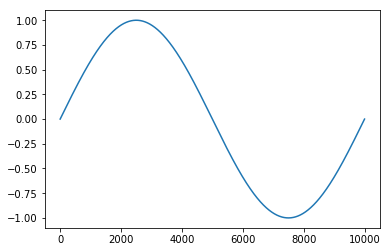

In [59]:
# Check the result
plt.plot(np.sin(angles));

### 2.2 line profiler

In [60]:
%%capture
!pip install line_profiler

In [61]:
%load_ext line_profiler
#%reload_ext line_profiler

In [62]:
%lprun 2 + 3

## 3. multiprocessing

In [2]:
import multiprocessing as mp
from itertools import product
from pyramidmaker import makerow

In [3]:
print(dir(mp))

['Array', 'AuthenticationError', 'Barrier', 'BoundedSemaphore', 'BufferTooShort', 'Condition', 'Event', 'JoinableQueue', 'Lock', 'Manager', 'Pipe', 'Pool', 'Process', 'ProcessError', 'Queue', 'RLock', 'RawArray', 'RawValue', 'SUBDEBUG', 'SUBWARNING', 'Semaphore', 'SimpleQueue', 'TimeoutError', 'Value', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'active_children', 'allow_connection_pickling', 'connection', 'context', 'cpu_count', 'current_process', 'freeze_support', 'get_all_start_methods', 'get_context', 'get_logger', 'get_start_method', 'log_to_stderr', 'process', 'reducer', 'reduction', 'set_executable', 'set_forkserver_preload', 'set_start_method', 'sys', 'util']


In [3]:
ncore = mp.cpu_count()
ncore

4

In [4]:
!cat pyramidmaker.py

#! /usr/bin/env python

def makerow(nums):
    try:
        rownum, ntotal = nums
    except:
        raise Exception('Not enough elements to unpack!')
    rowstr = list('0'*(ntotal-rownum-1) + '1'*(2*rownum+1) + '0'*(ntotal-rownum-1))
    row = [int(r) for r in rowstr]
    return row


### Using Pool()

In [34]:
pool = mp.Pool(ncore)

if __name__ == '__main__':
    params = product(range(100), [100])
    rows = pool.map(makerow, params)

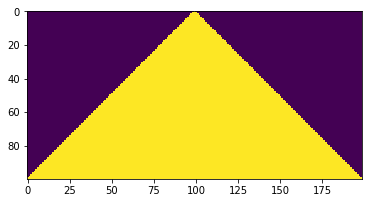

In [35]:
pyramid_pool = np.asarray(rows, dtype='int')
plt.imshow(pyramid_pool);

### Using Process()

In [ ]:
out = mp.Queue()
prcs = [mp.Process(target=makerow, args=([ith, 100])) for ith in range(100)]

for p in prcs:
    p.start()

for p in prcs:
    p.join()
    
results = [out.get() for p in prcs]

In [ ]:
pyramid_pool = np.asarray(rows, dtype='int')
plt.imshow(pyramid_pool);

### Speed comparison

In [19]:
n = 5000

#### Ordinary program with for loop

In [20]:
%%timeit
rows_normal = []
for ith in range(n):
    rows_normal.append(makerow([ith, n]))

1 loop, best of 3: 12.4 s per loop


#### Program using parallelized map

In [21]:
%%timeit
pool = mp.Pool(ncore)
if __name__ == '__main__':
    params = product(range(n), [n])
    rows_parallel = pool.map(makerow, params)

1 loop, best of 3: 9.05 s per loop


#### Program using asynchronous parallelized map

In [22]:
%%timeit
pool = mp.Pool(ncore)
if __name__ == '__main__':
    params = product(range(n), [n])
    p_async = pool.map_async(makerow, params)
    row_async = p_async.get()
    pool.close()

1 loop, best of 3: 8.94 s per loop


## 4. Interfacing with other languages
### 4.1 Cython and C extension

In [36]:
def pyfac(n):
    if n <= 1:
        return 1
    return n * pyfac(n - 1)

In [37]:
%timeit pyfac(50)

100000 loops, best of 3: 9.52 µs per loop


In [38]:
%load_ext Cython

In [39]:
%%cython

def cyfac(n):
    if n <= 1:
        return 1
    return n * cyfac(n - 1)

def cyfac_tdef(double n):
    if n <= 1:
        return 1.0
    return n * cyfac_tdef(n - 1)

cpdef double cyfac_ftdef(double n):
    if n <= 1:
        return 1.0
    return n * cyfac_ftdef(n - 1)

In [40]:
%timeit cyfac(50)

100000 loops, best of 3: 4.76 µs per loop


In [41]:
%timeit cyfac_tdef(50)

100000 loops, best of 3: 2.92 µs per loop


In [42]:
%timeit cyfac_ftdef(50)

The slowest run took 10.11 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 209 ns per loop


### 4.2 Matlab
Connection to Matlab on a local computer within Jupyter notebook through the packages [matlab_kernel](https://github.com/Calysto/matlab_kernel) or [pymatbridge](https://github.com/arokem/python-matlab-bridge)

In [43]:
%%capture
!pip install pymatbridge

In [44]:
%load_ext pymatbridge

C:\ProgramData\Anaconda3\lib\site-packages\IPython\nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


Starting MATLAB on ZMQ socket tcp://127.0.0.1:60546
Send 'exit' command to kill the server
..................MATLAB started and connected!


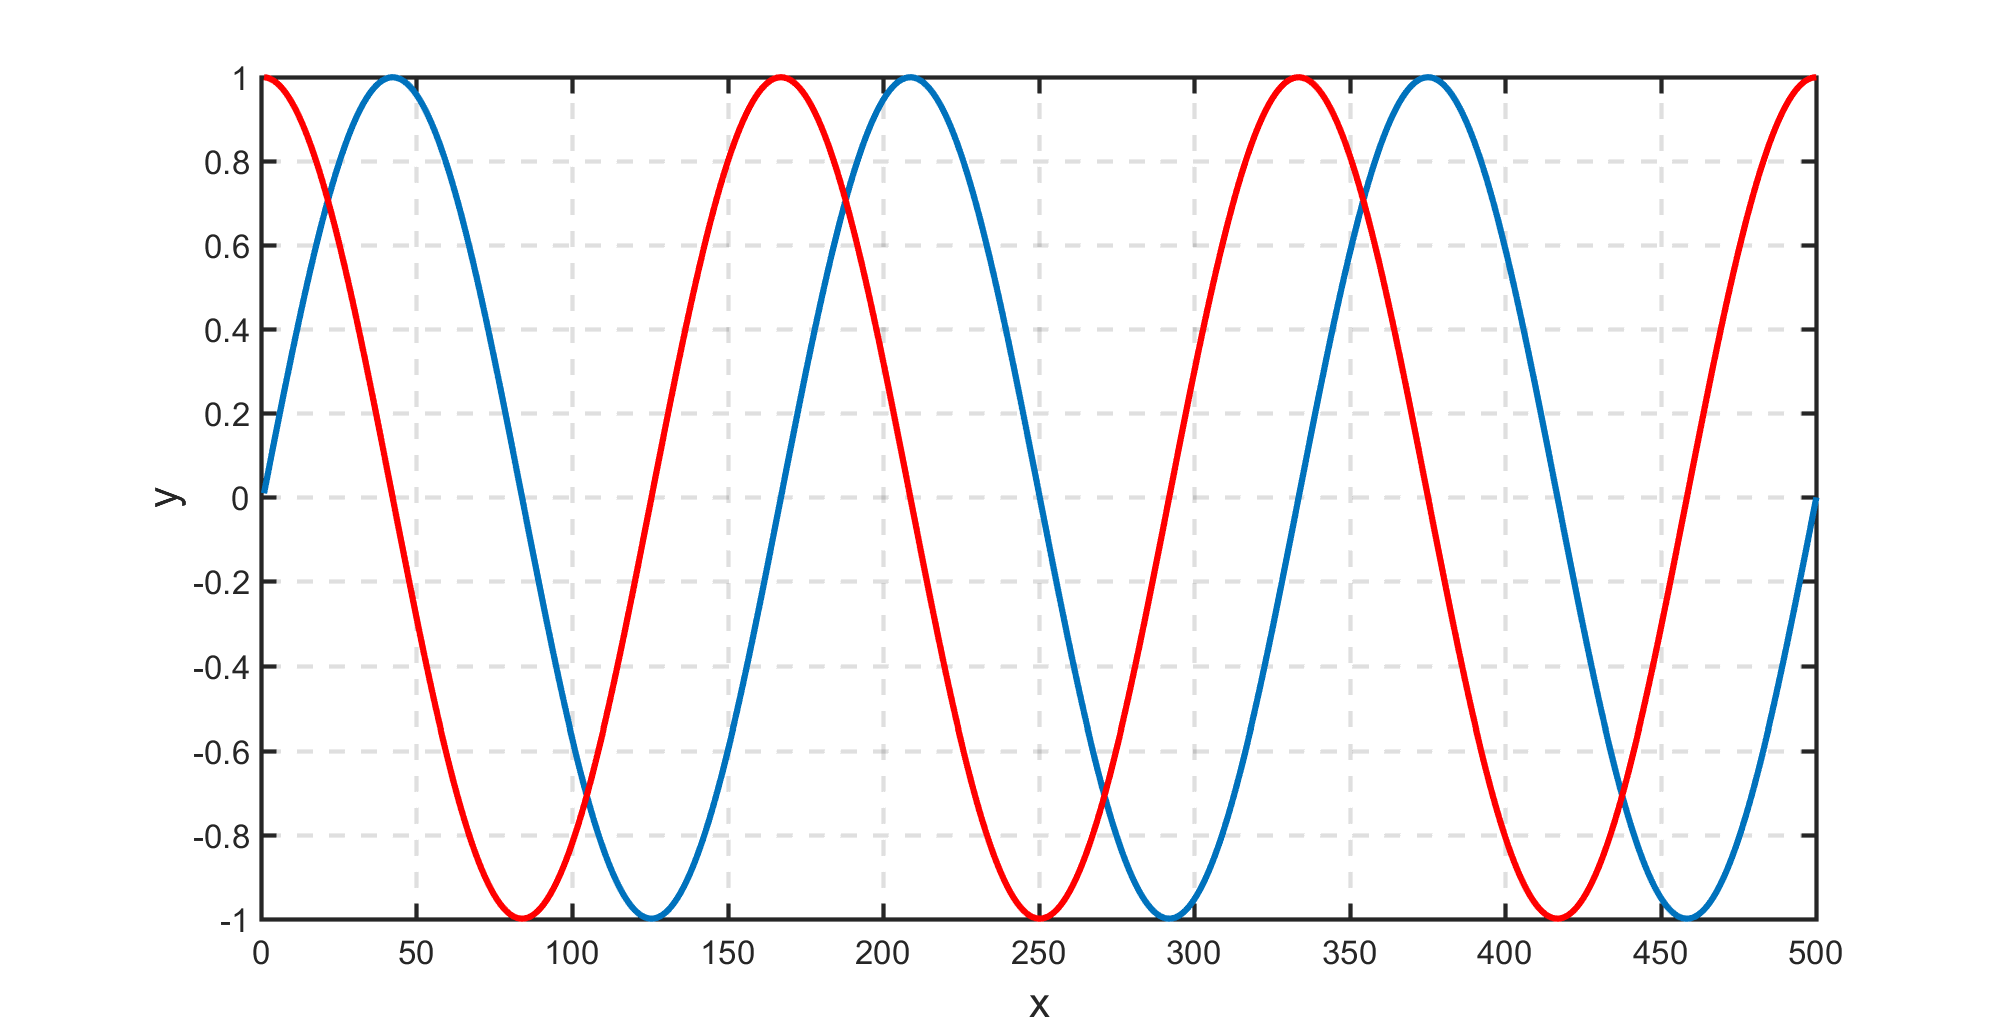

In [45]:
%%matlab
h = figure;
a = linspace(0.01,6*pi,500);
plot(sin(a), 'linewidth',3)
grid on
hold on
plot(cos(a),'r', 'linewidth',3)
hold off
set(gca, 'linewidth', 2, 'GridLineStyle','--', 'FontSize', 16)
xlabel('x', 'FontSize', 20)
ylabel('y', 'FontSize', 20)

### 4.3 Julia

### 4.4 HTML/Javascript

In [46]:
from IPython.core.display import display, HTML
from string import Template
import json

In [47]:
HTML('''
<h1>Hello World!</h1>
''')